In [1]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

from qurveros import plottools
from qurveros.optspacecurve import OptimizableSpaceCurve
from qurveros.qubit_bench import simulator
from qurveros.settings import settings

import qurveros.plot_configs

import matplotlib
matplotlib.rcParams['figure.dpi'] = 150

In the previous examples, we focused solely on extracting the control fields
from a given spacecurve.

In this example, we will introduce the optimization of the curve's parameters
to achieve desired properties.

We will use the curve as in the constant pulse example,
but now the circle is traversed using a frequency parameter `omega`.

In [2]:
def circle(x,omega):

    return [jnp.cos(omega*x), jnp.sin(omega*x), 0]

The `OptimizableSpaceCurve` class is simply an extension of the `SpaceCurve`
class that allows the optimization of a spacecurve using the auxiliary
parameters.

In [3]:
optspacecurve = OptimizableSpaceCurve(curve=circle,
                                      order=0,
                                      interval=[0, 2*jnp.pi],
                                      params=0.5)

We start with $\omega=0.5$ which leads to a curve that is not closed.

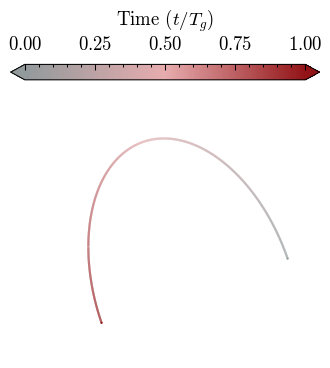

In [4]:
optspacecurve.evaluate_frenet_dict()
optspacecurve.plot_position()
plt.gca().view_init(elev=90, roll=50)

We will now define some loss functions that accept the frenet dictionary
and enforce some particular conditions when they are minimized.

In [5]:
def closed_curve_loss(frenet_dict):
    
    # The endpoints are calculated directly from the curve function
    # and minimized to zero.

    endpoint_diff = frenet_dict['curve'][-1] - frenet_dict['curve'][0]

    return jnp.sum(endpoint_diff**2)

def freq_loss(frenet_dict):

    # This loss forces the optimization to find solutions of non-zero frequency.
    # When omega goes to zero, the curve becomes constant hence the control
    # fields are zero.

    # Implementation detail: The frenet dictionary contains the parameter
    # values at each x. Here we need only one value since it remains constant 
    # throughout the evolution.

    omega = frenet_dict['params'][0] 
    
    return -jnp.log10(omega)

The optimization loss is prepared using the respective method.

It accepts an arbitrary sequence of lists of the form [`loss_function`, `weight`].
The total loss function is the linear combination of each loss multiplied by the associated weight.

In [6]:
optspacecurve.prepare_optimization_loss(
        [closed_curve_loss,1.],
        [freq_loss,1]
)

The class exposes the initialization of the parameters, in case they are not
provided when an instance is created.

In [7]:
optspacecurve.initialize_parameters(0.5)

We can now optimize the curve using optax. The default implementation is 1,000 steps of gradient descent with learning rate $\alpha=0.01$.

In [8]:
optspacecurve.optimize()


Optimizing parameters:	100.00%


The new parameter is:

In [9]:
optspacecurve.get_params()

Array(1.00547155, dtype=float64)

To avoid confusion between the optimized and non-optimized parameters,
the frenet dictionary, the robustness_properties and the control dictionary are
set to `None` every time the parameters are updated after the class instantiation. 
We will need to invoke the same methods again to find the curve
with the new parameters.

In [10]:
optspacecurve.evaluate_frenet_dict()

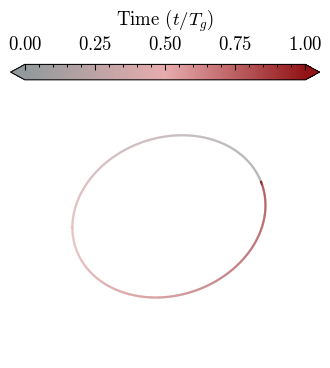

In [11]:
optspacecurve.plot_position()
plt.gca().view_init(elev=90, roll=50)

The curve is now closed!

In [12]:
optspacecurve.evaluate_robustness_properties()
optspacecurve.get_robustness_properties()

|       closed_test       : 	 2.9610e-05
|     curve_area_test     : 	 2.5055e-02
|    tantrix_area_test    : 	 3.9912e+01
|           CFI           : 	 2.5055e-02


Let's simulate the derived pulses.

In [13]:
optspacecurve.evaluate_control_dict('XY')

In [14]:
sim_dict = simulator.simulate_control_dict(optspacecurve.get_control_dict(),
                                           np.eye(2))

In [15]:
np.round(sim_dict['avg_gate_fidelity'],6)

np.float64(0.999803)

The average gate fidelity is not as high as in the constant pulse example. 

Remember that in the optimization's losses, we did not specify to fix the gate for a particular target operation and the gradient descent simply converged to the minimum of matching the endpoints.

In contrast, when BARQ is employed to optimize a particular space curve, the curve remains closed and the gate is fixed for unit fidelity at every optimization step.

We can update the parameter manually to set the known value.

In [16]:
optspacecurve.set_params(1)
optspacecurve.evaluate_frenet_dict()

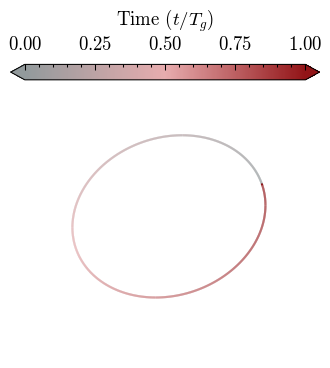

In [17]:
optspacecurve.plot_position()
plt.gca().view_init(elev=90, roll=50)

In [18]:
optspacecurve.evaluate_robustness_properties()
optspacecurve.get_robustness_properties()

|       closed_test       : 	 1.5196e-33
|     curve_area_test     : 	 2.5330e-02
|    tantrix_area_test    : 	 3.9478e+01
|           CFI           : 	 2.5330e-02


Comparing to the previous robustness properties, the `closed_test` value is 
significantly smaller compared to the case where optimization is demonstrated.
A simple solution is to increase the number of iterations or optimize with
a different learning rate, until the optimal value is reached.

In [19]:
optspacecurve.evaluate_control_dict('XY')
sim_dict = simulator.simulate_control_dict(optspacecurve.get_control_dict(),
                                           np.eye(2))
np.round(sim_dict['avg_gate_fidelity'],6)

np.float64(1.0)

Lastly, since curiosity leaves the cat in superposition, we can investigate the evolution of the optimization.

We can recover the history of the optimization using an instance method.

Text(0.5, 0, 'Optimization step')

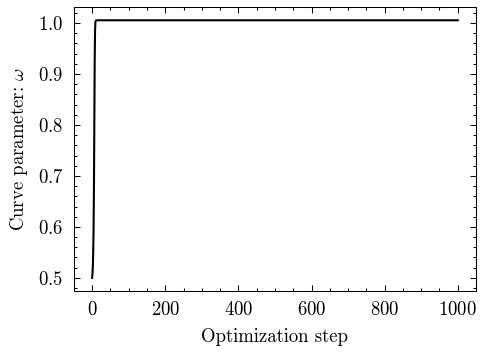

In [20]:
plt.plot(optspacecurve.get_params_history(),'-k')
plt.ylabel(r'Curve parameter: $\omega$')
plt.xlabel(r'Optimization step')

The usual indexing of the spacecurve still holds, but if we index with a string that corresponds to an index, optimization information is returned in the indices of the `params_history` attribute. Using the value of '-1', we can obtain the desired information at the end of the optimization.

In [21]:
optspacecurve['-1']

{'param_value': Array(1.00547155, dtype=float64),
 'loss_value': Array(-0.001188, dtype=float64),
 'loss_grad_value': Array(-1.02114497e-14, dtype=float64)}

The gradient becomes very small quite early in the optimization stage.

In [22]:
optspacecurve['12']

{'param_value': Array(1.00543718, dtype=float64),
 'loss_value': Array(-0.00118796, dtype=float64),
 'loss_grad_value': Array(-0.00272674, dtype=float64)}

Text(0.5, 0, 'Optimization step')

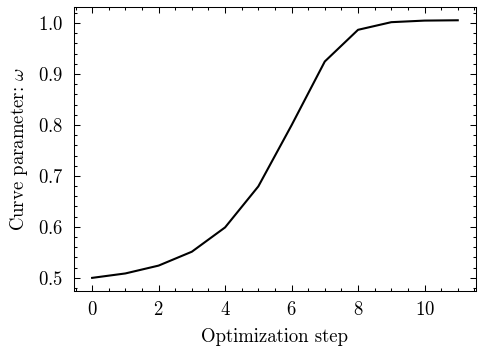

In [23]:
plt.plot(optspacecurve['0:12']['param_value'],'-k')
plt.ylabel(r'Curve parameter: $\omega$')
plt.xlabel(r'Optimization step')

We can investigate the shape of the curve throughout the first steps using the method `update_params_from_opt_history(opt_step)`.

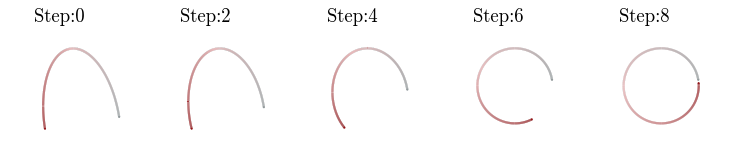

In [24]:
fig, axs = plt.subplots(1,5, layout='constrained', subplot_kw={'projection': '3d'}, 
                        figsize=plt.figaspect(0.5))

for step, ax in enumerate(axs):
    ax.set_axis_off()
    optspacecurve.update_params_from_opt_history(2*step)
    optspacecurve.evaluate_frenet_dict()
    curve = optspacecurve[:]['curve']
    curve_param = optspacecurve[:]['length']/(optspacecurve[:]['length'][-1])

    plottools.plot_curve(curve, curve_param, ax)
    ax.text2D(0.2,1,f'Step:{2*step}', transform = ax.transAxes, 
              fontsize = matplotlib.rcParams['axes.labelsize'])
    ax.view_init(elev=90, roll=40)

In [25]:
print(settings)

    CURVE_POINTS    : 	 4096
     SIM_POINTS     : 	 4096
   QUTIP_OPTIONS    : 	 {'max_step': 0.0001220703125, 'atol': 1e-14, 'rtol': 1e-14}
  NUM_REALIZATIONS  : 	 200
 FIR_TERMS_FRACTION : 	 0.9
  DELTA_Z_INTERVAL  : 	 (-3, 0)
  EPSILON_INTERVAL  : 	 (-4, -1)
     MAX_POINTS     : 	 12
  COUNTOUR_LEVELS   : 	 (-9, -8, -7, -6, -5)
     NUM_DERIVS     : 	 5
  INFLECTION_NORM   : 	 0.001
      FIX_NORM      : 	 0.01
     NUM_SINGLS     : 	 5
    ANGLE_K_MAX     : 	 3
    FIELD_NAMES     : 	 ['omega', 'phi', 'delta']
     OPT_POINTS     : 	 4096
    CURVE_COLORS    : 	 ['#929A9C', '#E7ACAE', '#921417']
    FIELD_COLORS    : 	 ['#000000', '#305CDE', '#A67B5B']
  COUNTOUR_COLORS   : 	 ['#09B8B8', '#5B5585']

